# 2. Exploratory Data Analysis (EDA)

**Goal:** Explore the processed training data (`interactions_train.csv`, `video_metadata.csv`) generated in Notebook 1. The insights gained here will inform feature engineering, model selection, and evaluation strategies.

**Key Questions:**
*   What are the basic statistics of the training interactions?
*   How sparse is the user-item interaction data?
*   What is the distribution of interactions per user and per item? (Long-tail?)
*   How is the interaction signal (`watch_ratio`, `positive_interaction`) distributed?
*   Are there any temporal patterns in the interactions?
*   What is the nature of the item metadata (categories/tags)?

## Setup
Import libraries and configure plotting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # For safely evaluating string representations of lists
from collections import Counter
import os

# Plotting settings
plt.rcParams["figure.figsize"] = (18, 8) # Adjusted for potentially wider plots
sns.set_theme(style="whitegrid") # Using seaborn themes
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load Processed Data
Load the output files from Notebook 1.

In [2]:
DATA_DIR = "../data/"

interactions_train_path = os.path.join(DATA_DIR, "interactions_train.csv")
video_metadata_path = os.path.join(DATA_DIR, "video_metadata.csv")

try:
    train_df = pd.read_csv(interactions_train_path)
    metadata_df = pd.read_csv(video_metadata_path)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure Notebook 1 (Data Preparation) was run successfully.")
    exit()

print(f"Loaded {len(train_df)} training interactions.")
print(f"Loaded metadata for {metadata_df['item_id'].nunique()} items.")

Loaded 3741256 training interactions.
Loaded metadata for 10728 items.


## Explore Training Interactions (`interactions_train.csv`)

### Basic Information & Stats

In [3]:
print("Training Interactions Info:")
train_df.info()

print("\nTraining Interactions Head:")
print(train_df.head())

print("\nTraining Interactions Description:")
# Describe numerical columns, including the interaction signals
print(train_df[['watch_ratio', 'timestamp', 'positive_interaction']].describe())

# Check for missing values (should be none if prepared correctly)
print("\nMissing values in training data:")
print(train_df.isnull().sum())

Training Interactions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741256 entries, 0 to 3741255
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   user_id               int64  
 1   item_id               int64  
 2   watch_ratio           float64
 3   timestamp             float64
 4   positive_interaction  int64  
dtypes: float64(2), int64(3)
memory usage: 142.7 MB

Training Interactions Head:
   user_id  item_id  watch_ratio     timestamp  positive_interaction
0     6190     9559     1.981442  1.593801e+09                     1
1     6190     1926     0.787826  1.593801e+09                     0
2     6190     9553     0.964642  1.593807e+09                     0
3     6190     9530     0.112044  1.593807e+09                     0
4     6190     6760     0.154852  1.593807e+09                     0

Training Interactions Description:
        watch_ratio     timestamp  positive_interaction
count  3.741256e+06  3.74125

### User-Item Interaction Statistics
Calculate basic counts and sparsity.

In [4]:
n_users = train_df['user_id'].nunique()
n_items = train_df['item_id'].nunique()
n_interactions = len(train_df)

# Sparsity Calculation: Number of non-zero entries / total possible entries
# Note: This assumes a dense interaction matrix which isn't fully appropriate here, 
# but gives a general idea of data density.
if n_users > 0 and n_items > 0:
    sparsity = 1 - n_interactions / (n_users * n_items)
else:
    sparsity = 1 # Avoid division by zero

print(f"Number of unique users in training data: {n_users}")
print(f"Number of unique items in training data: {n_items}")
print(f"Number of training interactions: {n_interactions}")
print(f"Approximate User-Item Matrix Sparsity: {sparsity:.4f} ({sparsity*100:.2f}% sparse)")

Number of unique users in training data: 1411
Number of unique items in training data: 2993
Number of training interactions: 3741256
Approximate User-Item Matrix Sparsity: 0.1141 (11.41% sparse)


### Interaction Distributions
Analyze how many interactions individual users and items have.

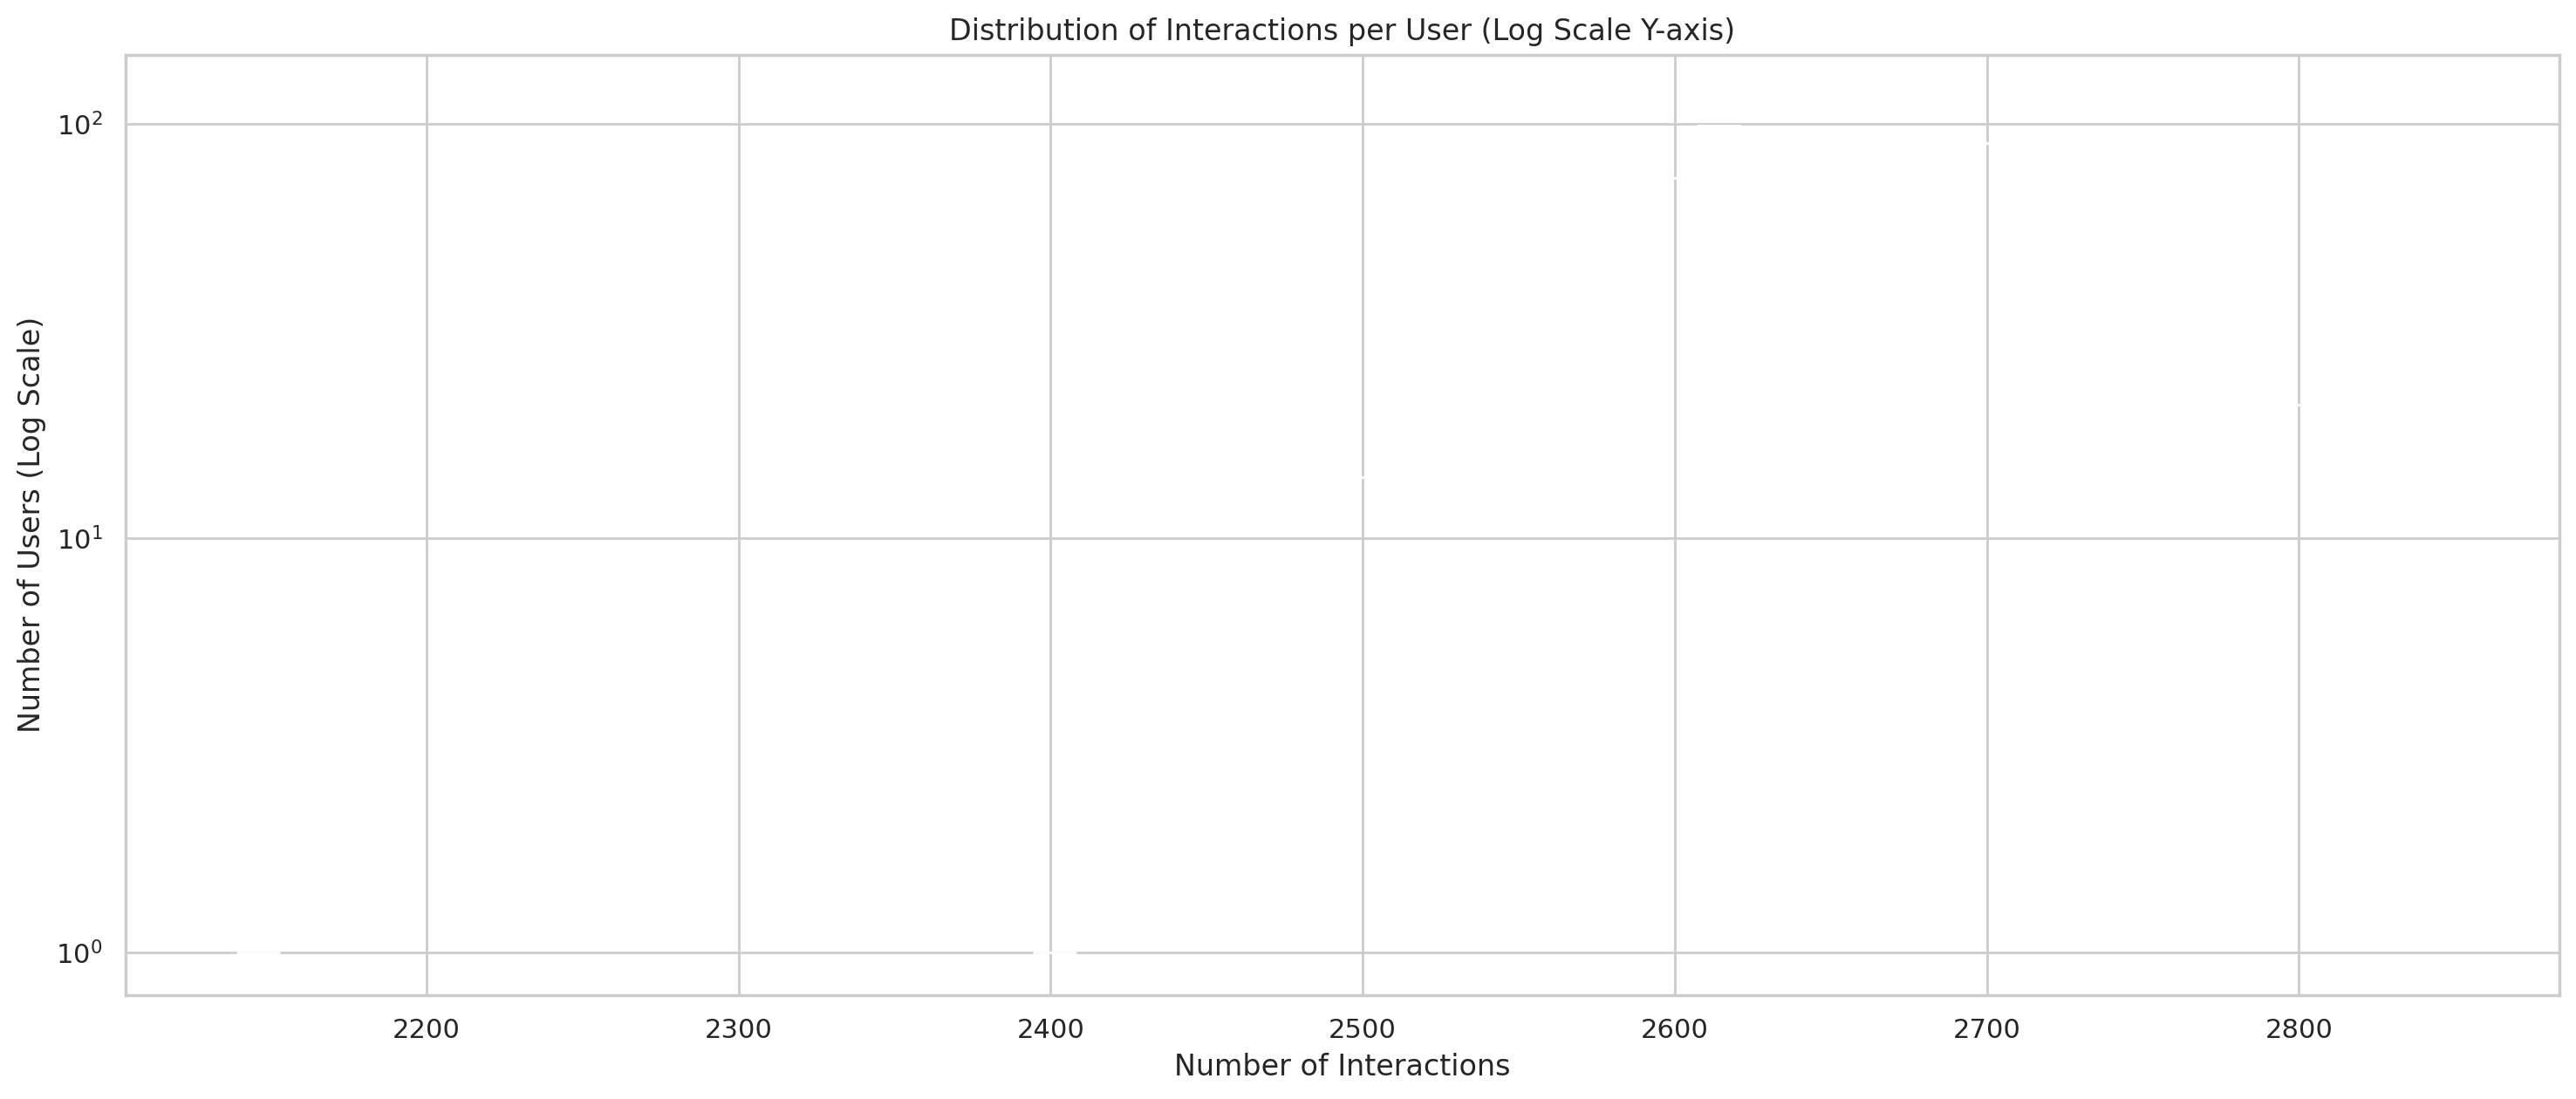

Interactions per user statistics:
count    1411.000000
mean     2651.492558
std        81.023308
min      2139.000000
25%      2602.500000
50%      2654.000000
75%      2706.000000
max      2848.000000
dtype: float64


In [5]:
user_interaction_counts = train_df.groupby('user_id').size()

plt.figure(figsize=(18, 7))
sns.histplot(user_interaction_counts, bins=50, log_scale=(False, True)) # Log scale for count visibility
plt.title('Distribution of Interactions per User (Log Scale Y-axis)')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users (Log Scale)')
plt.show()

print("Interactions per user statistics:")
print(user_interaction_counts.describe())

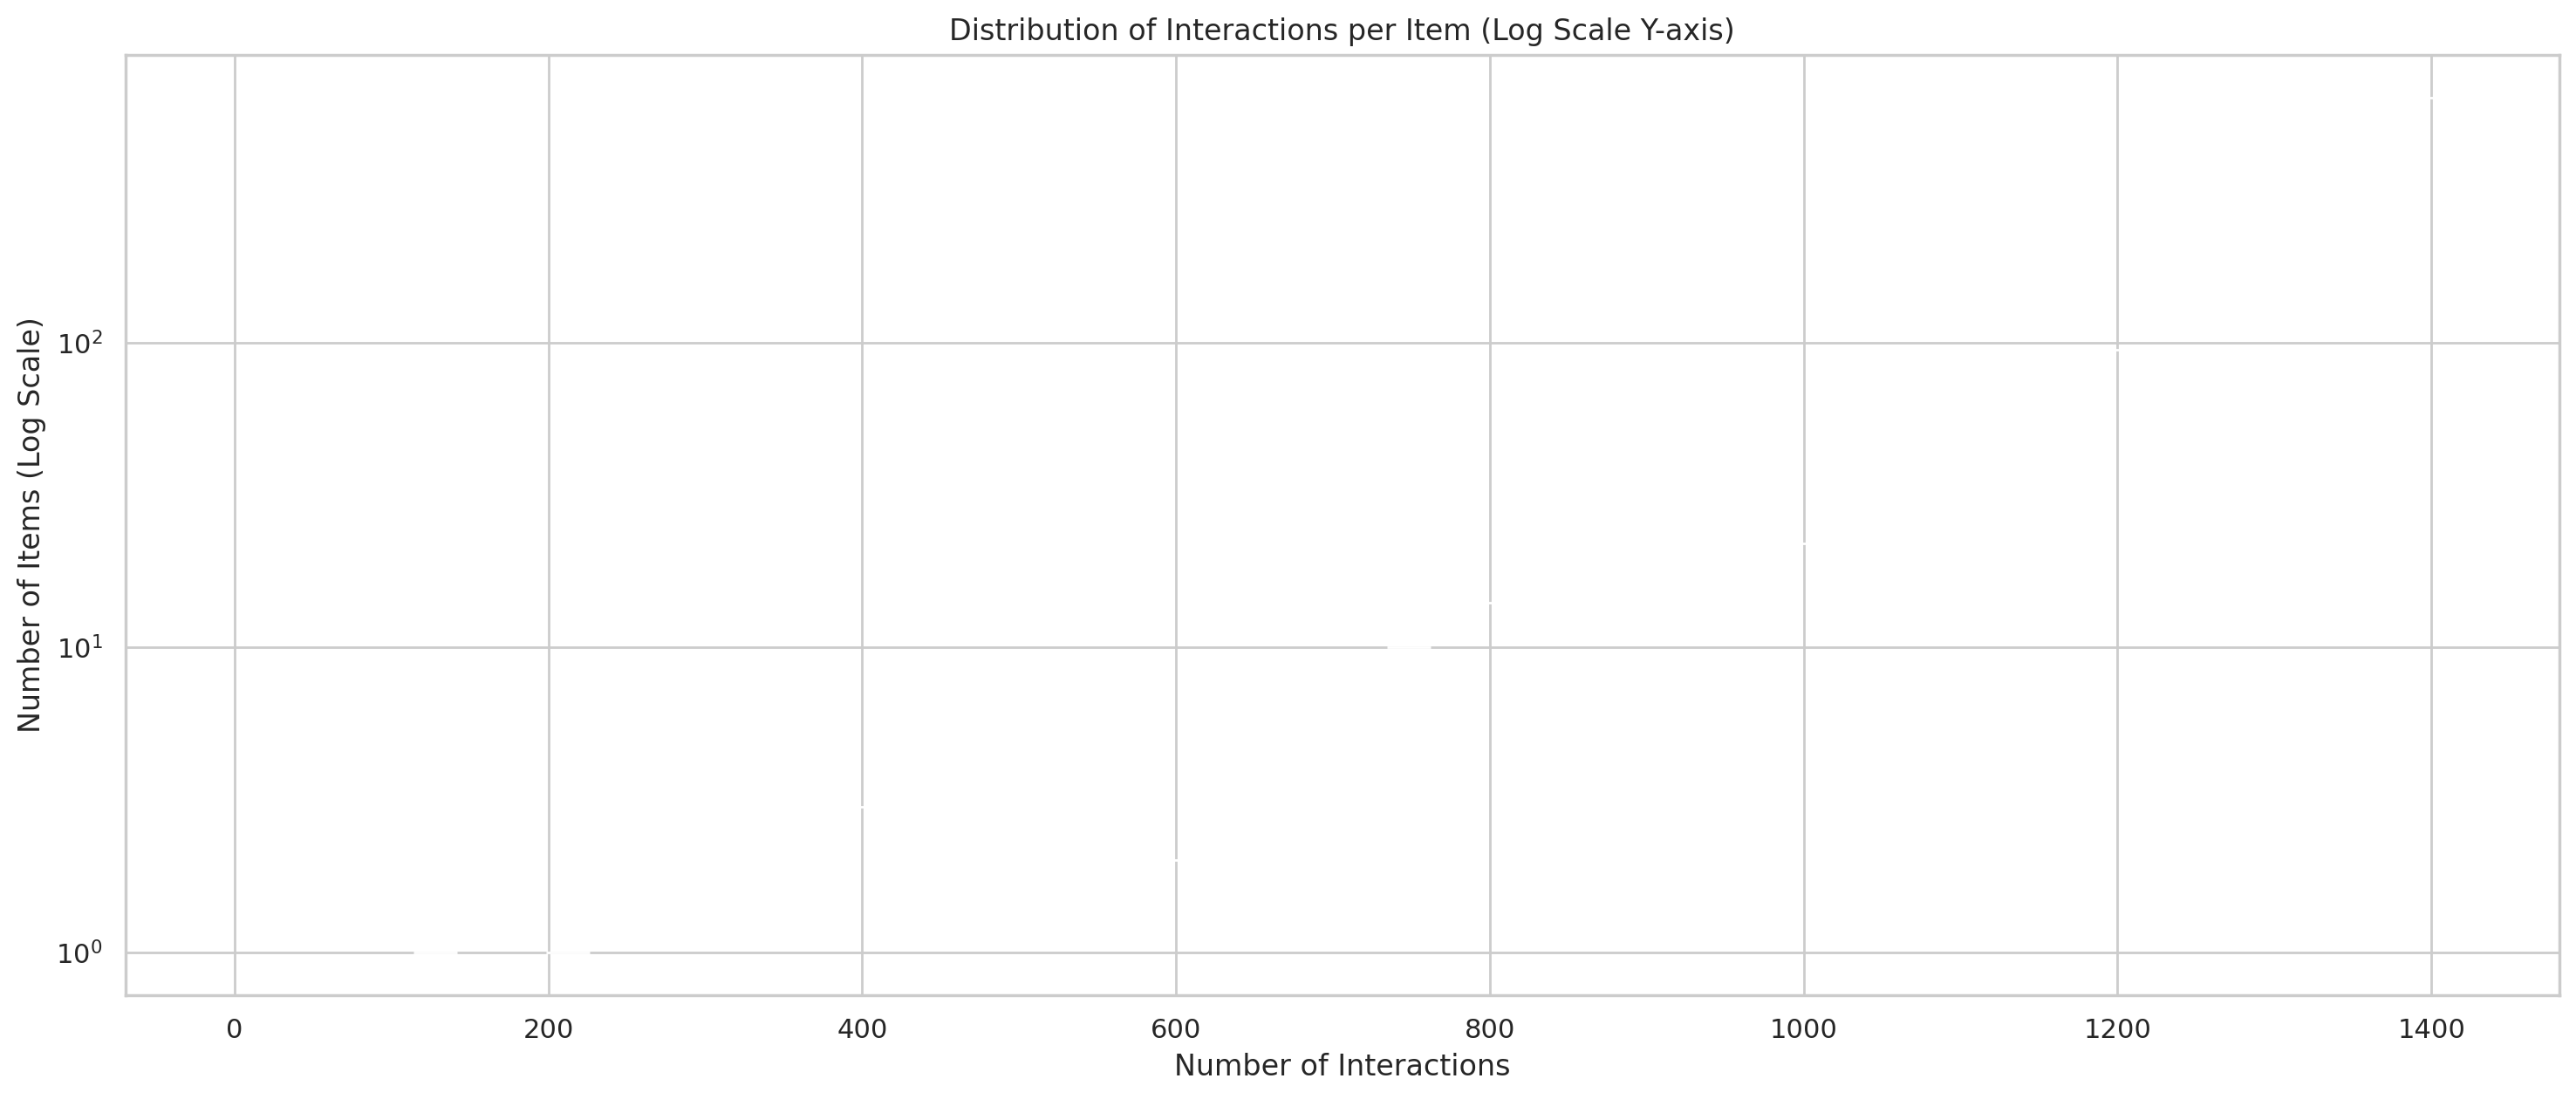

Interactions per item statistics:
count    2993.000000
mean     1250.002005
std       227.950576
min         1.000000
25%      1228.000000
50%      1332.000000
75%      1376.000000
max      1411.000000
dtype: float64


In [6]:
item_interaction_counts = train_df.groupby('item_id').size()

plt.figure(figsize=(18, 7))
sns.histplot(item_interaction_counts, bins=50, log_scale=(False, True))
plt.title('Distribution of Interactions per Item (Log Scale Y-axis)')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items (Log Scale)')
plt.show()

print("Interactions per item statistics:")
print(item_interaction_counts.describe())

*Observations on Distributions:*
*   The data is highly sparse, meaning most user-item pairs have no recorded interaction.
*   Both user and item interaction counts exhibit a **long-tail distribution**. A small number of users/items have a very large number of interactions (high popularity/activity), while the vast majority have relatively few.
*   *Implications:* 
    *   **Popularity Bias:** Models might easily learn to recommend popular items, potentially ignoring relevant niche items.
    *   **Cold Start:** Recommending to users with few interactions or recommending less popular items will be challenging for purely collaborative approaches.
    *   **Feature Engineering:** Interaction counts themselves could be useful features for the ranking model.

### Interaction Signal Analysis (`watch_ratio`, `positive_interaction`)

Distribution of 'positive_interaction' in training data:
Positive Interaction Rate: 0.3279
positive_interaction
0    0.672107
1    0.327893
Name: proportion, dtype: float64


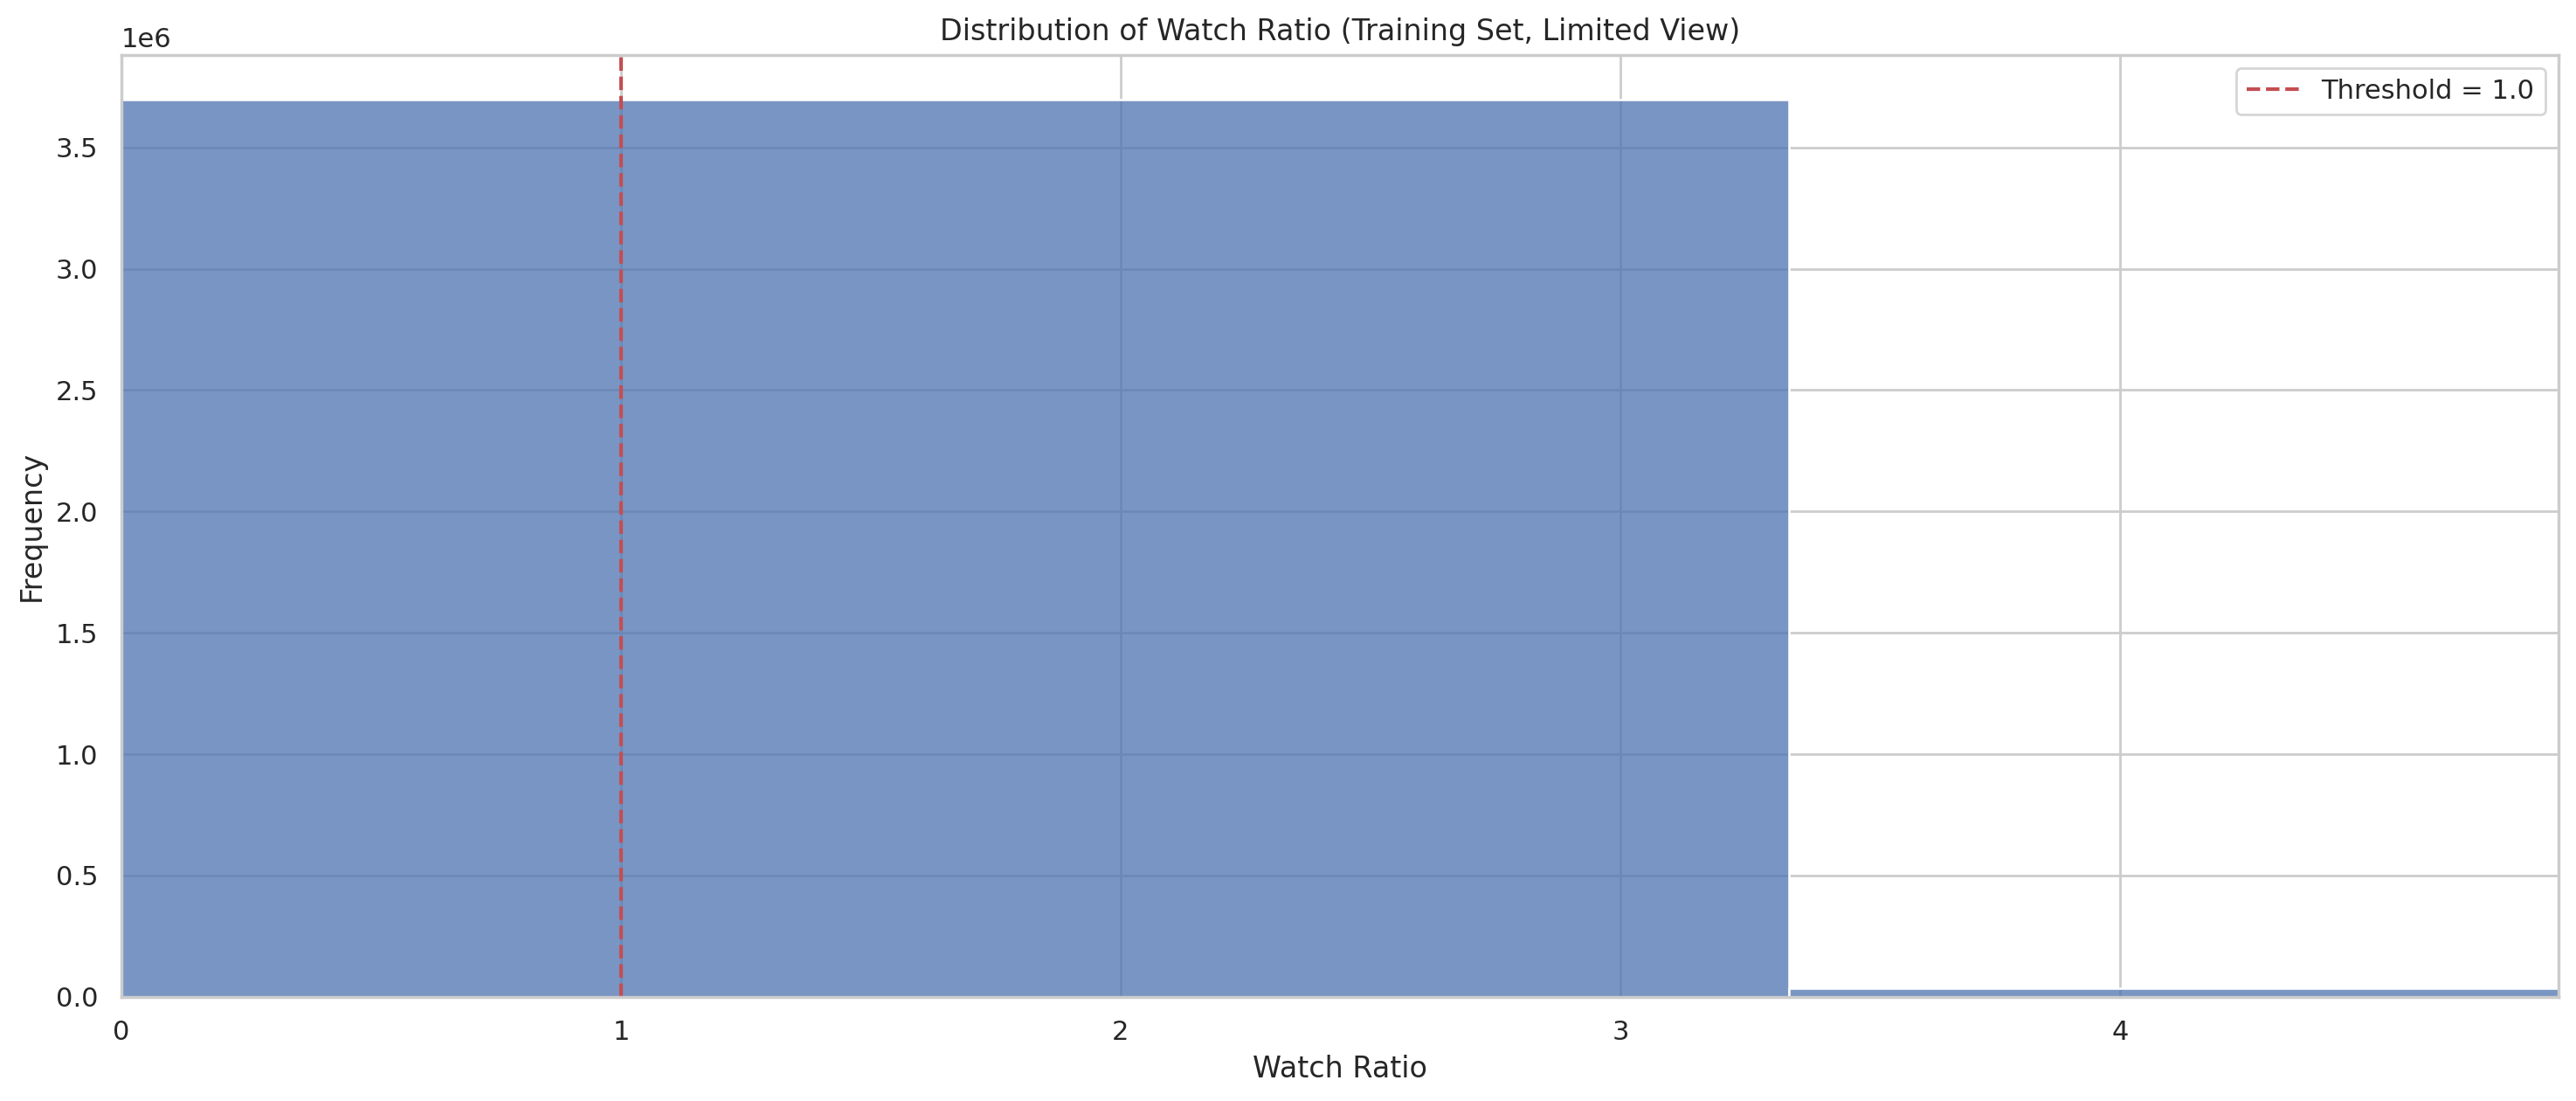

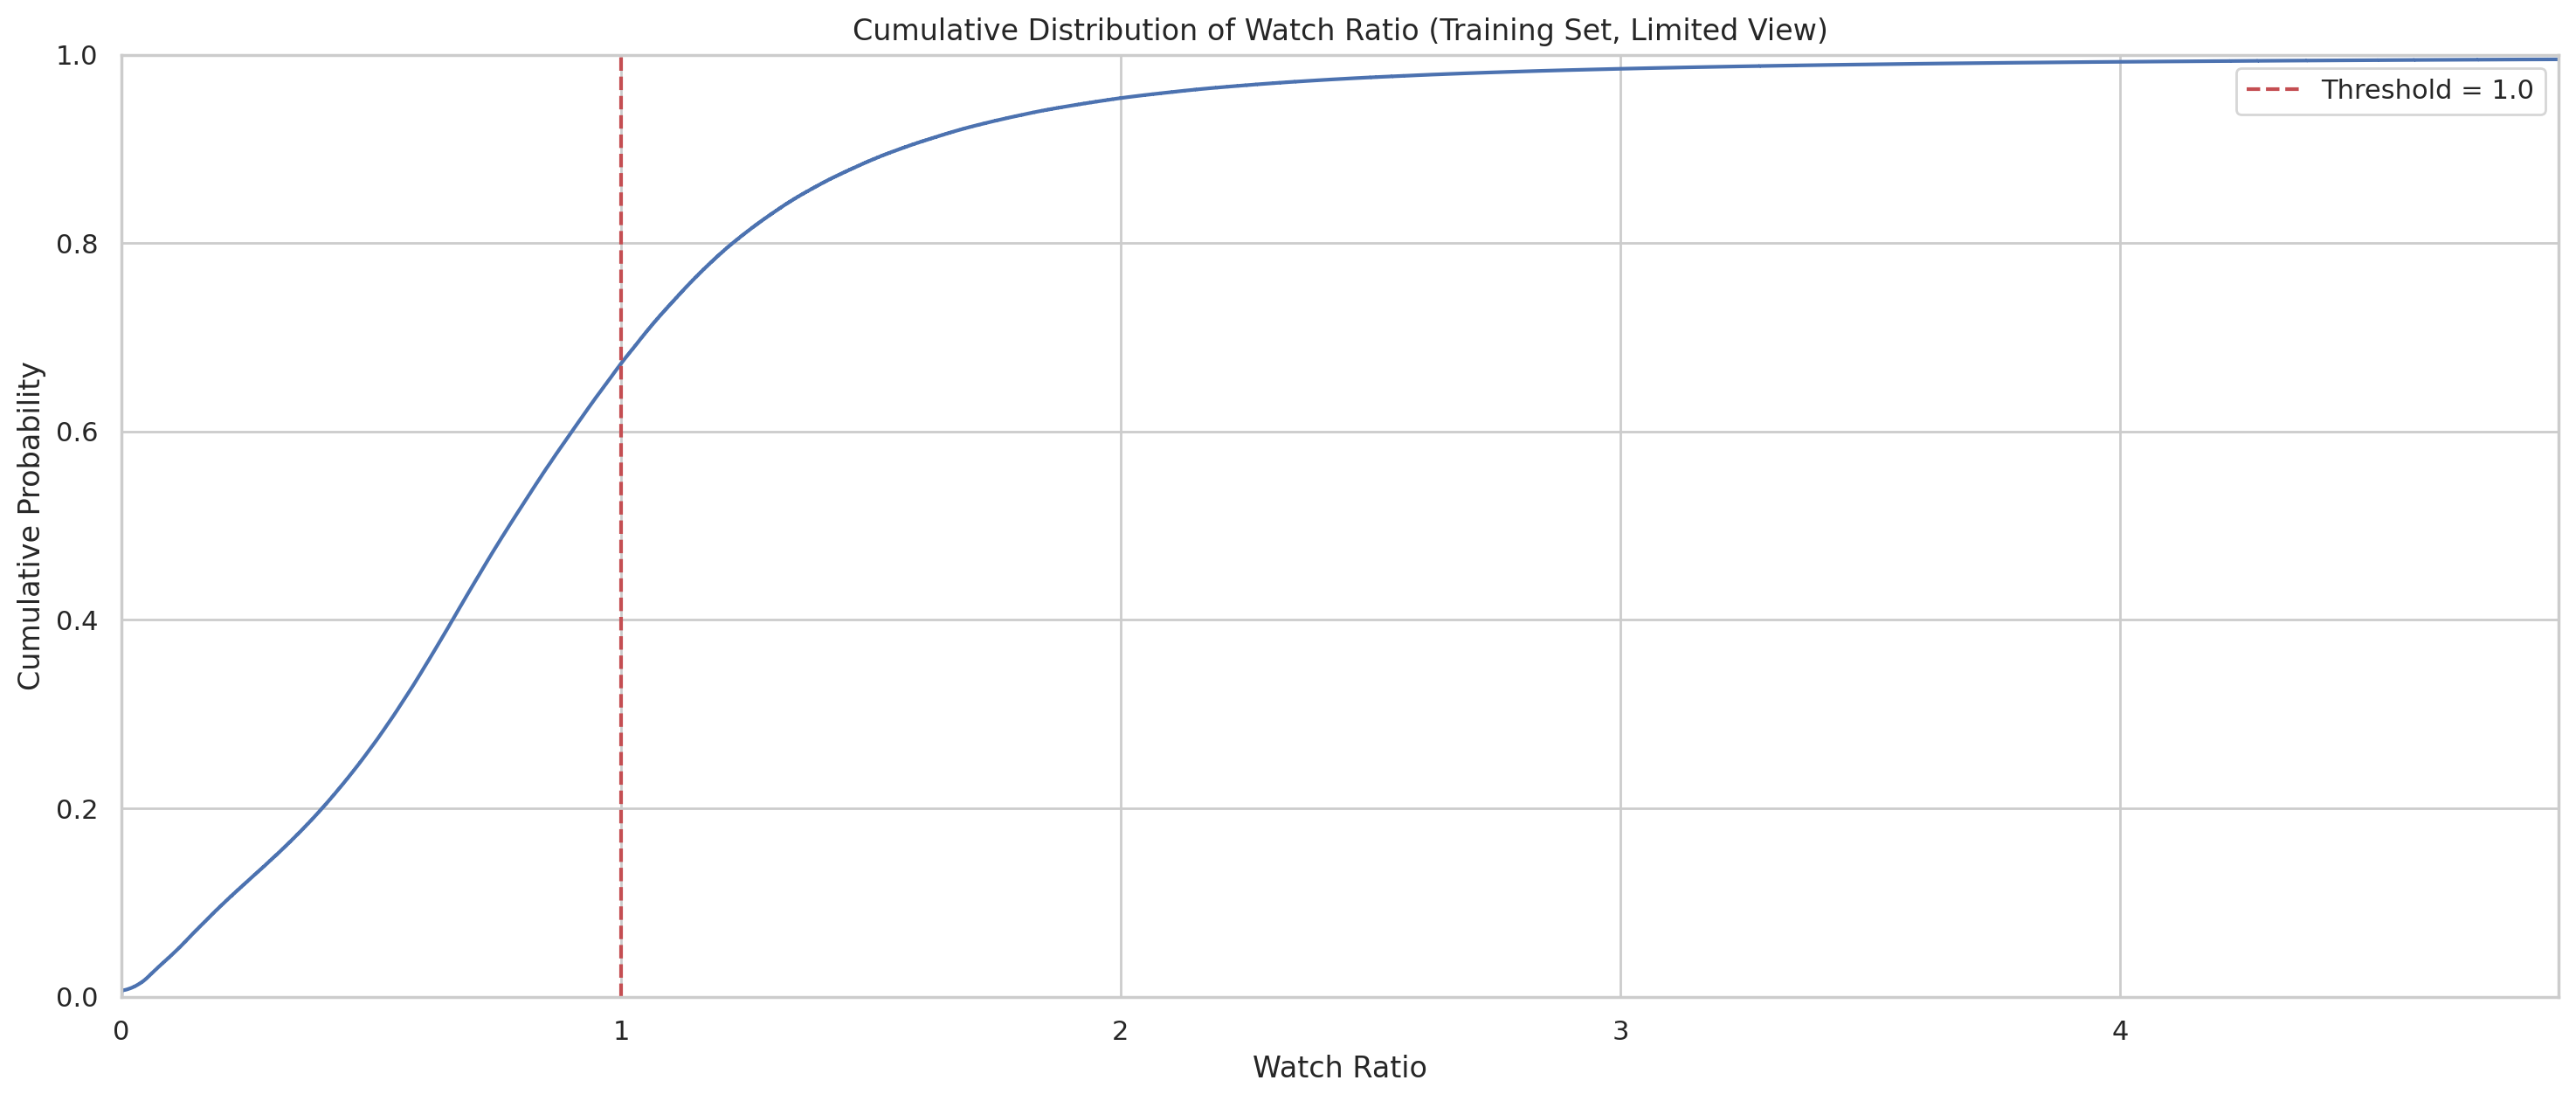

In [7]:
print("Distribution of 'positive_interaction' in training data:")
positive_rate = train_df['positive_interaction'].mean()
print(f"Positive Interaction Rate: {positive_rate:.4f}")
print(train_df['positive_interaction'].value_counts(normalize=True))

# Plot watch_ratio distribution, focusing on the region around the threshold
plt.figure(figsize=(18, 7))
sns.histplot(train_df['watch_ratio'], bins=100, kde=False)
plt.title('Distribution of Watch Ratio (Training Set, Limited View)')
plt.xlabel('Watch Ratio')
plt.ylabel('Frequency')
# Limit view for clarity, e.g., show up to 99th percentile or a fixed range like 0-5
plt.xlim(0, min(5, train_df['watch_ratio'].quantile(0.995)))
plt.axvline(x=1.0, color='r', linestyle='--', label='Threshold = 1.0') # Show threshold used in Notebook 1
plt.legend()
plt.show()

# Plotting the CDF (Cumulative Distribution Function) is also useful
plt.figure(figsize=(18, 7))
sns.ecdfplot(data=train_df, x="watch_ratio")
plt.title('Cumulative Distribution of Watch Ratio (Training Set, Limited View)')
plt.xlabel('Watch Ratio')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.xlim(0, min(5, train_df['watch_ratio'].quantile(0.995)))
plt.axvline(x=1.0, color='r', linestyle='--', label='Threshold = 1.0')
plt.legend()
plt.show()

*Observations on Interaction Signal:*
*   The dataset is imbalanced regarding the `positive_interaction` label (derived from `watch_ratio >= 1.0`). This is typical in recommendation datasets (users interact with far fewer items than they are exposed to).
*   The `watch_ratio` distribution shows a significant number of interactions below 1.0, but also a substantial portion above 1.0 (indicating users watched the entire video, possibly multiple times or longer videos).
*   *Implications:*
    *   **Threshold Choice:** The choice of `1.0` seems reasonable as it captures a significant portion (~32%) of interactions as positive, representing completed views. Other thresholds (e.g., `0.5` or `2.0` as suggested in the dataset description) could be tested, potentially changing the label balance and model performance.
    *   **Evaluation Metrics:** Due to imbalance, metrics like AUC (used in LightGBM training) are suitable. For final ranking evaluation, Precision@K, Recall@K, and NDCG@K are appropriate.

### Temporal Analysis
Examine how interactions are distributed over time.

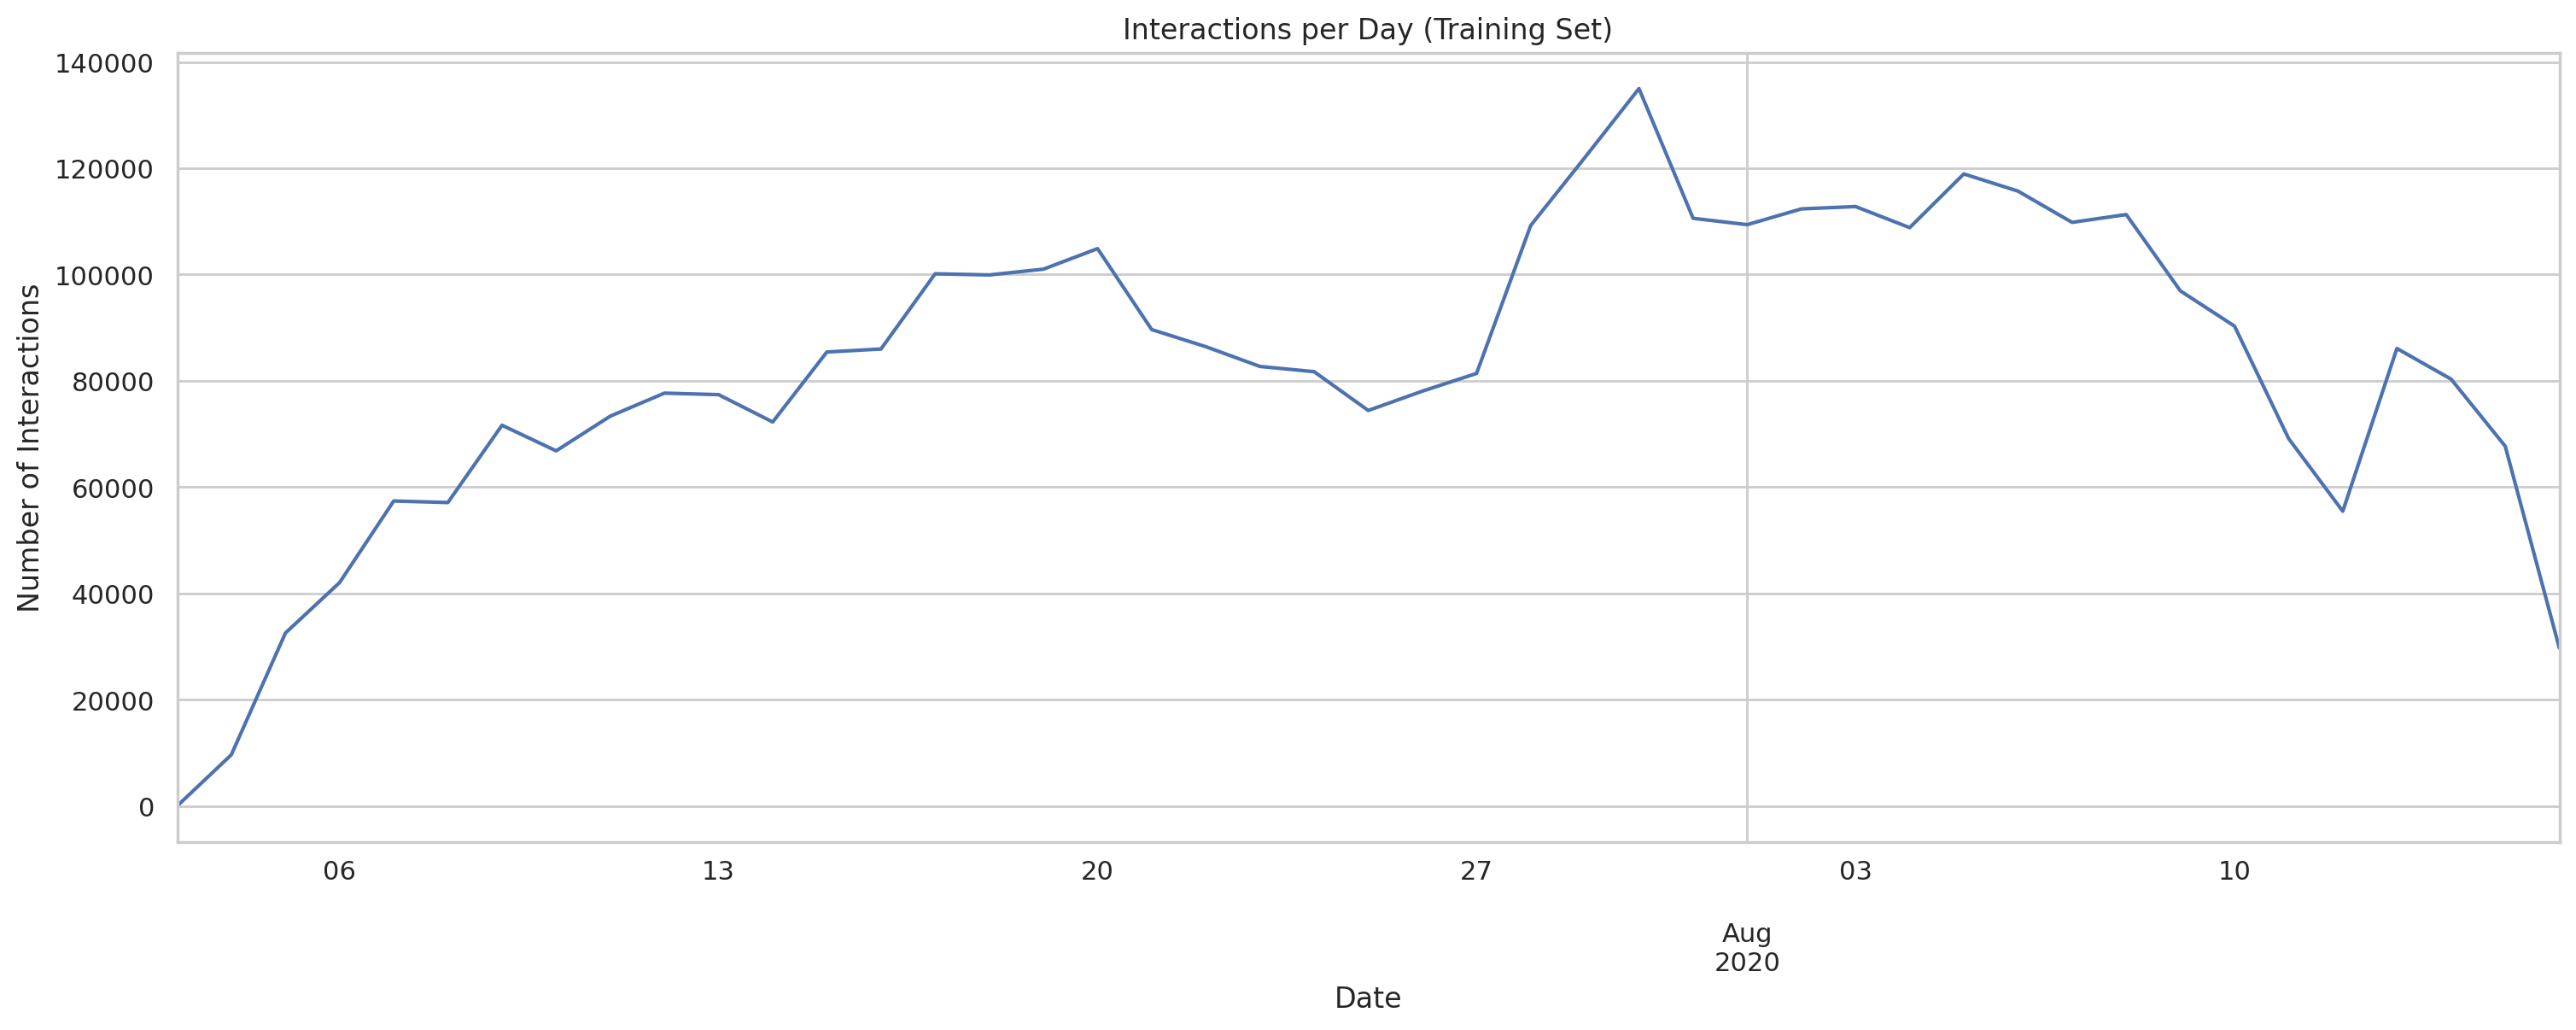

Interaction Counts Per Day Summary:
count        45.000000
mean      83139.022222
std       28991.839413
min           8.000000
25%       71645.000000
50%       85426.000000
75%      108827.000000
max      134993.000000
Name: user_id, dtype: float64


In [8]:
# Convert timestamp to datetime for easier resampling
train_df['datetime'] = pd.to_datetime(train_df['timestamp'], unit='s')

plt.figure(figsize=(18, 6))
interactions_per_day = train_df.set_index('datetime')['user_id'].resample('D').count()
interactions_per_day.plot()
plt.title('Interactions per Day (Training Set)')
plt.ylabel('Number of Interactions')
plt.xlabel('Date')
plt.show()

print("Interaction Counts Per Day Summary:")
print(interactions_per_day.describe())

*Observations on Time Distribution:*
*   The plot shows the volume of interactions over the training period. Check for significant trends, seasonality, or abrupt changes.
*   *Implications:*
    *   **Splitting Strategy:** The time-based split performed in Notebook 1 is appropriate for capturing temporal dynamics and evaluating the model's ability to predict future interactions.
    *   **Time Features:** If significant daily/weekly patterns exist, features like 'hour_of_day' or 'day_of_week' could be valuable for the ranking model.
    *   **Concept Drift:** If there are strong trends, the model's performance might degrade over time (concept drift), suggesting the need for periodic retraining in a real-world scenario.

## Explore Video Metadata (`video_metadata.csv`)

In [9]:
print("Video Metadata Info:")
metadata_df.info()

print("\nVideo Metadata Head:")
print(metadata_df.head())

# Check item coverage compared to training interactions
items_in_train = train_df['item_id'].nunique()
items_in_meta = metadata_df['item_id'].nunique()
print(f"\nItems in training data: {items_in_train}")
print(f"Items in metadata file: {items_in_meta}")
if items_in_meta < items_in_train:
    print("Warning: Metadata does not cover all items in training data.")

Video Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10728 entries, 0 to 10727
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  10728 non-null  int64 
 1   feat     10728 non-null  object
dtypes: int64(1), object(1)
memory usage: 167.8+ KB

Video Metadata Head:
   item_id     feat
0        0      [8]
1        1  [27, 9]
2        2      [9]
3        3     [26]
4        4      [5]

Items in training data: 2993
Items in metadata file: 10728


### Analyze Category Features (`feat` column)

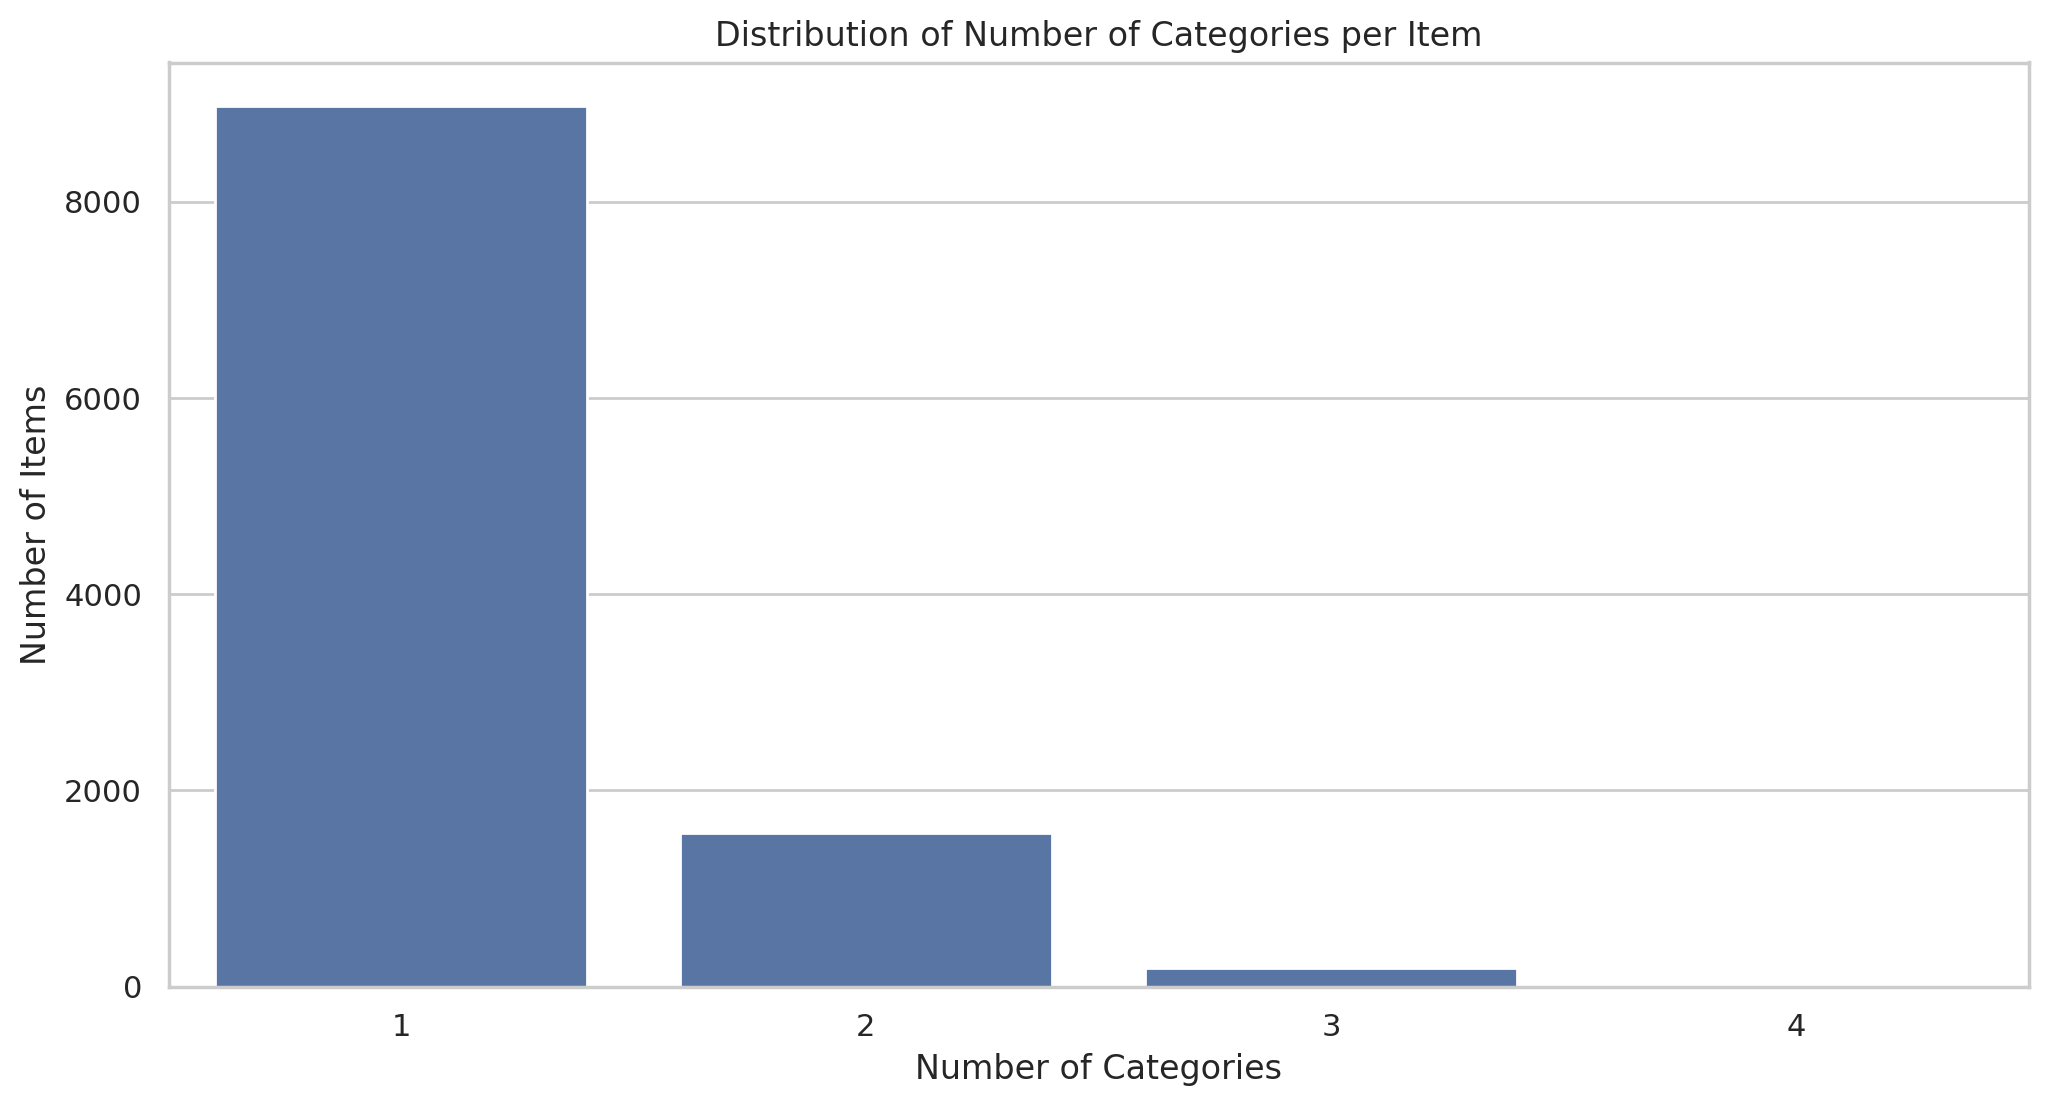

Statistics for number of categories per item:
count    10728.000000
mean         1.183166
std          0.436205
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: num_categories, dtype: float64

Number of unique category IDs found: 31


/tmp/ipykernel_3532/564939666.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cat_ids), y=list(counts), order=list(cat_ids), palette="viridis")


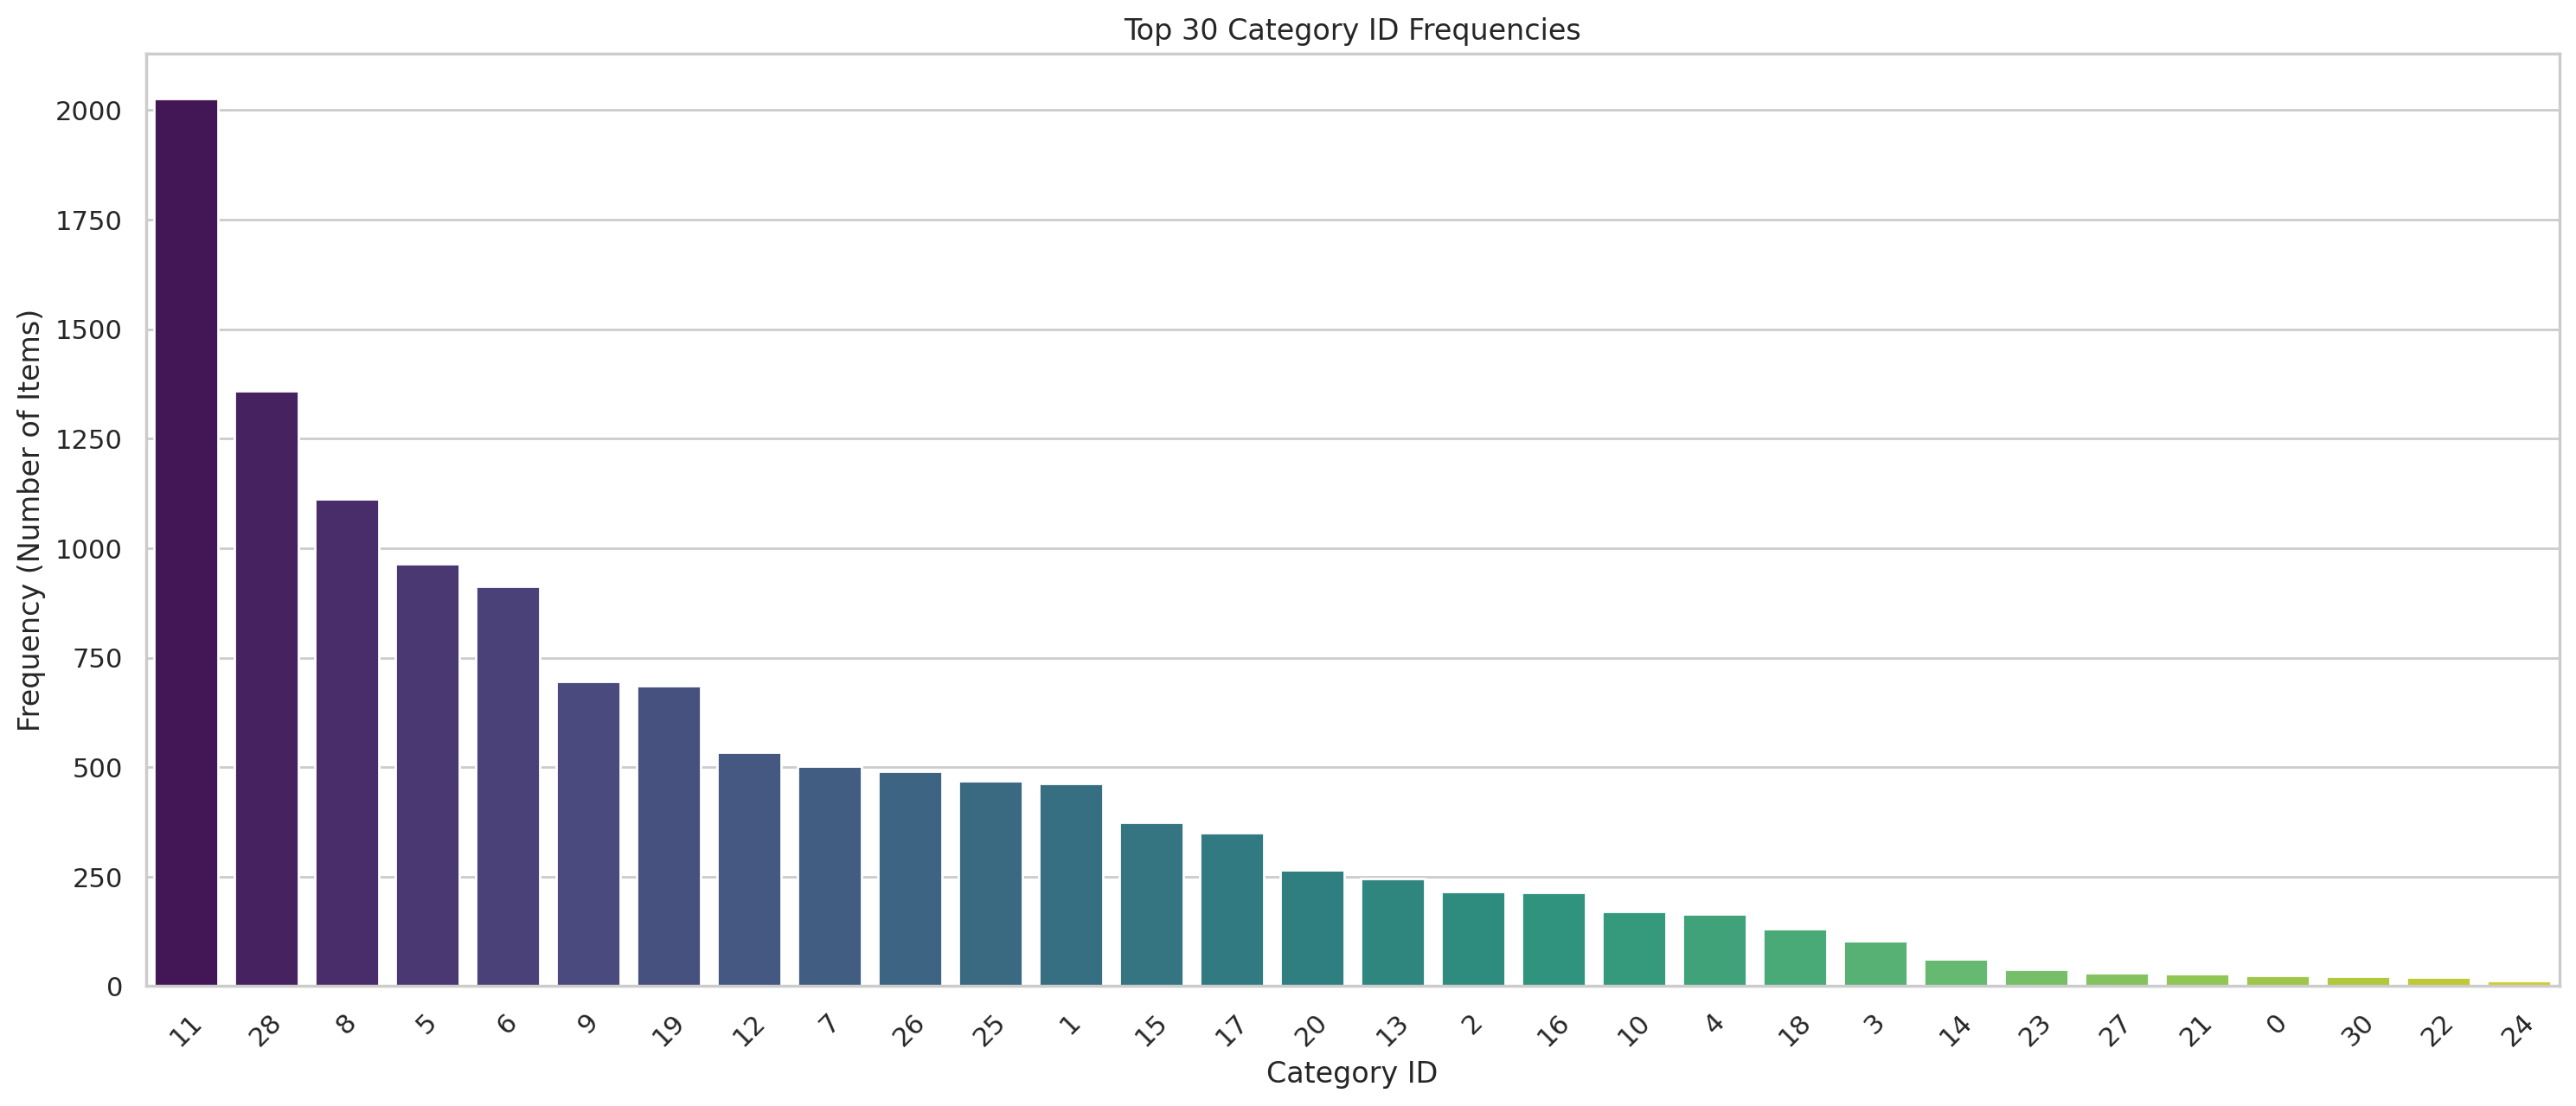

In [10]:
# Define a safe function to parse the string representation of list
def parse_list_string(s):
    try:
        # Handles potential NaN or non-string inputs
        if isinstance(s, str):
            return ast.literal_eval(s)
        return []
    except (ValueError, SyntaxError):
        return [] # Return empty list on parsing errors

metadata_df['feat_list'] = metadata_df['feat'].apply(parse_list_string)

# Distribution of number of categories per item
metadata_df['num_categories'] = metadata_df['feat_list'].apply(len)
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata_df, x='num_categories')
plt.title('Distribution of Number of Categories per Item')
plt.xlabel('Number of Categories')
plt.ylabel('Number of Items')
plt.show()
print("Statistics for number of categories per item:")
print(metadata_df['num_categories'].describe())

# Count occurrences of each category ID across all items
all_categories = Counter()
for feat_list in metadata_df['feat_list']:
    all_categories.update(feat_list)

print(f"\nNumber of unique category IDs found: {len(all_categories)}")

# Plot top N most frequent categories
top_n = 30
most_common_categories = all_categories.most_common(top_n)

if most_common_categories:
    cat_ids, counts = zip(*most_common_categories)
    plt.figure(figsize=(18, 7))
    sns.barplot(x=list(cat_ids), y=list(counts), order=list(cat_ids), palette="viridis")
    plt.title(f'Top {top_n} Category ID Frequencies')
    plt.xlabel('Category ID')
    plt.ylabel('Frequency (Number of Items)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No categories found or parsed.")

*Observations on Metadata:*
*   Most items seem to have a small number of associated category IDs (often just one).
*   There's a limited number of unique category IDs overall.
*   The frequency distribution of category IDs also shows a long tail - some categories are very common, others are rare.
*   *Implications:*
    *   **Content Features:** The `feat` column provides categorical features. These can be used in content-based models or as item features in the hybrid ranker (e.g., using multi-hot encoding or interaction counts between user history and item categories).
    *   **Diversity:** The category information can be used to explicitly promote diversity in recommendations (e.g., using MMR re-ranking based on category similarity or ensuring category coverage in the top-N list).

## EDA Summary & Conclusions

1.  **Sparsity & Long Tail:** The dataset is sparse with long-tail user/item activity. This necessitates models that handle sparsity well (like Matrix Factorization - ALS) and techniques to mitigate popularity bias.
2.  **Interaction Signal:** The `watch_ratio >= 1.0` threshold provides a reasonable binary target for positive interaction, though the data is imbalanced. Ranking metrics (NDCG, Precision@K, Recall@K) will be important for evaluation.
3.  **Temporal Aspect:** The time-based split is appropriate. Temporal features might enhance the ranking model.
4.  **Metadata:** Item categories offer potential for content-based features and diversification strategies.

**Next Step:** Proceed to `3_Model_Training.ipynb` to build the ALS candidate generator and the LightGBM ranker, incorporating these insights (e.g., using embeddings from ALS and item/user features in the ranker).